In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Deep learning approach: sklearn MLP

Ways to frame problem:

- Recover colourmap from pseudocolour, then lookup data from code book.
- Recover data from pseudocolour directly. 

## Make map data

In [2]:
def kernel(sizex, sizey):
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
    return g / g.sum()

In [3]:
import scipy.signal

def make_map(n, nx=100, ny=100, kernel_size=None, seed=None):

    imgs = []
    for i in range(n):
        rng = np.random.RandomState(seed=seed)
        z = rng.rand(nx, ny)
        kernel_size = kernel_size or (30, 30)
        f = kernel(*kernel_size)

        z = scipy.signal.convolve(z, f, mode='valid')
        z = (z - z.min())/(z.max() - z.min())
        imgs.append(z)
    
    return np.stack(imgs)

In [4]:
n = 1600
data = make_map(n, kernel_size=(29,29))

nv = 20
data_val = make_map(nv, kernel_size=(29,29))

In [5]:
data.shape

(1600, 42, 42)

## Make seismic data

In [264]:
raw = np.load("/home/matt/Dropbox/dev/geocomp-19/data/F3_volume_3x3_16bit.npy")

In [344]:
def rms(arr):
    epsilon=1e-6
    return np.sqrt(epsilon + np.sum(arr**2)/arr.size)

In [345]:
def make_seismic(raw, n=1600, s=41):
    slices = []
    while len(slices) < n:
        x, y, z = [np.random.randint(0, h) for h in np.array(raw.shape)-np.array([s, 0, s])]
        this = raw[x:x+s, y, z:z+s]
        if rms(this) < 1:
            # Make sure it's not blank
            continue
        slices.append(this.T)
    data = np.array(slices, dtype=np.int64)

    mi, ma = np.percentile(data, (0.5, 99.5))
    data[data < mi] = mi
    data[data > ma] = ma

    data[np.isnan(data)] = 0
    mi, ma = np.min(data), np.max(data)
    data = (data - mi) / (ma - mi)

    data = data.astype(np.float32)
    return data

In [416]:
n = 2500
data = make_seismic(raw, n=n)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [381]:
np.min(data), np.max(data)

(0.0, 1.0)

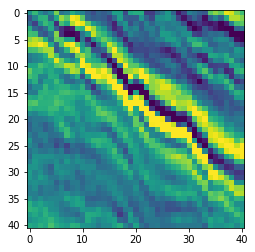

In [382]:
plt.imshow(data[313])

In [429]:
nv = 48
data_val = make_seismic(raw, n=nv)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


## Make `X` and `y`

In [25]:
CMAPS = {'Perceptually Uniform Sequential':
                            ['viridis', 'inferno', 'plasma', 'magma'],
         'Sequential':     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd',],
         'Sequential2':     ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter'],
         'Diverging':      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic'],
         'Seismic':      ['bwr', 'RdBu', 'RdGy', 'Greys', 'gray', 'Spectral',
                             'seismic', 'bone', 'bone_r',
                          'bwr_r', 'RdBu_r', 'RdGy_r', 'Greys_r', 'gray_r', 'seismic_r'],
         'SeismicDiv':      ['bwr', 'RdBu', 'RdGy', 'Spectral','seismic', 
                          'bwr_r', 'RdBu_r', 'RdGy_r', 'Spectral_r', 'seismic_r'],
         'SeismicRamp':      ['Greys', 'gray_r', 'bone_r', 'Blues'],
         'Qualitative':    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3'],
         'Miscellaneous':  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'],
         'Rainbow':  ['nipy_spectral', 'jet',
                             'gist_rainbow', 'hsv'],
        }

In [319]:
import os
import logging
from matplotlib import cm
from functools import reduce

logging.basicConfig(level='INFO')

def save_image_files(y, path:str) -> None:
    """
    Make and save an image (via a matplotlib figure)
    for every image (first dimension slice) of y.
    
    Produces numbered PNG files in the path specified.
    
    Returns:
        None. Saves files as side-effect.
    """
    for i, img in enumerate(y):
        fig = plt.figure(frameon=False)
        fig.set_size_inches(5,5)

        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        # Note: interpolation introduces new colours.
        plt.imshow(img, cmap="jet", aspect='auto', interpolation="bicubic")
        
        if path is None:
            path = "."
        fname = os.path.join(path, f'img_{i:03d}.png')
        fig.savefig(fname, dpi=100)
        plt.close()
        logging.info(f"Saved {fname}")
    return

def make_pseudo(data, cmap:str='viridis', steps:int=128):
    cmap = cm.get_cmap(cmap)
    colours = cmap(np.linspace(0, 1, steps))[..., :3]
    pseudocolour = cmap(data)[..., :3]
    return pseudocolour, colours

def make_X_and_y(data,
                 cmap_group:str='Perceptually Uniform Sequential',
                 cmap_except:str='Qualitative',
                 steps:int=128) -> tuple:
    """
    Make a 3-channel pseudo-colour array for each
    slice in y, using the specified colourmap.
    
    Args:
        data (ndarray): M x H x W array for M examples.
        cmap_group (str): Which group of cmaps to use. (Or
            can be a single cmap.)
        steps (int): The number of steps.
    
    Returns:
        tuple: Two ndarrays, the pseudocolour images,
            and the code book.
    """
    if cmap_group.lower() == 'all':
        cmaps = reduce(lambda x, y: x + y, CMAPS.values())
    else:
        cmaps = CMAPS.get(cmap_group)
        
    cmaps = [c for c in cmaps if c not in CMAPS.get(cmap_except)]
    
    pseudos, colours = [], []
    for d in data:
        try:
            cmap = np.random.choice(cmaps)
        except:
            cmap = cmap_group
        cmap = cm.get_cmap(cmap)
    
        p, c = make_pseudo(d, cmap, steps)
        
        pseudos.append(p)
        colours.append(c)
        
    return np.stack(pseudos), np.stack(colours)

In [8]:
def display_slices(data):
    fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(12,4))
    print(axs.shape)
    for ax, d in zip(axs.flatten(), data):
        ax.imshow(d, aspect='auto')
        ax.axis('off')
    plt.show()

In [9]:
def luminance(arr):
    r, g, b = arr.T
    return np.sqrt(0.299 * r**2. + 0.587 * g**2. + 0.114 * b**2.)

In [489]:
steps = 24
group = 'SeismicRamp'

X, y = make_X_and_y(data, cmap_group=group, steps=steps)

In [490]:
X.shape, y.shape

((2500, 41, 41, 3), (2500, 24, 3))

(2, 6)


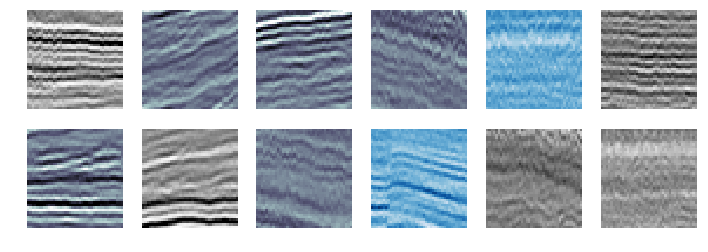

In [491]:
display_slices(X)

(2, 6)


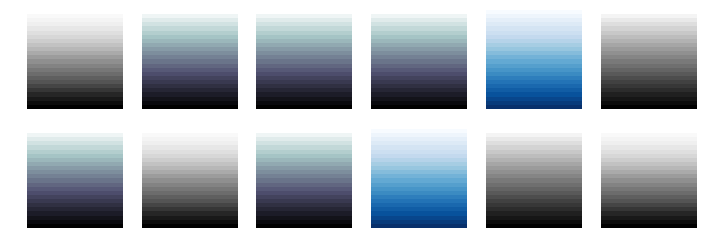

In [492]:
display_slices(y[:, :, None, :])

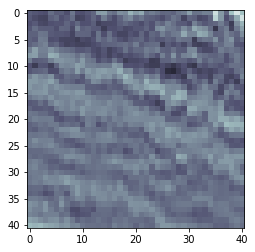

In [493]:
plt.imshow(X[3])

## Feature engineering

This is a sequence learning problem.

Want to constrain the output to only know about the colours in the training data.

Feels like we should be able to provide the training images and a code book, and ask only for the order of the colours in the image.

Options:

- Naive neighbours with shifts
- LSTM or spatial LSTM?
- Do a classification first, into discrete colours. Then give those colours to an ordering network.
- 'Lock' the colours together into a generated number or triple... but would have to span the full scale otheriw seit's no longer a regression problem. (I doubt this would work)

Another thought: use HLS space, or some other representation?

In [494]:
X.shape

(2500, 41, 41, 3)

In [495]:
Xo = X[:, :-1, :-1, :]
Xs = X[:, 1:, 1:, :]

In [496]:
assert Xo.shape == Xs.shape

In [497]:
X = np.hstack([Xo.reshape((n, -1, 3)), Xs.reshape((n, -1, 3))])

X.shape

(2500, 3200, 3)

In [498]:
X_val, y_val = make_X_and_y(data_val, cmap_group=group, steps=steps)

Xo = X_val[:, :-1, :-1, :]
Xs = X_val[:, 1:, 1:, :]

X_val = np.hstack([Xo.reshape((nv, -1, 3)), Xs.reshape((nv, -1, 3))])

In [499]:
X_val.shape

(48, 3200, 3)

## Training

### Deep neural net

In [500]:
n = X.shape[0]
assert n == y.shape[0]

X_train, y_train = X.reshape((n, -1)), y.reshape((n, -1))

In [501]:
X_val, y_val = X_val.reshape((nv, -1)), y_val.reshape((nv, -1))

In [502]:
from sklearn.neural_network import MLPRegressor

hidden = [
    6*steps,
    12*steps,
    6*steps,
    ]

nn = MLPRegressor(hidden_layer_sizes=hidden,
                  max_iter=10*n,
                  random_state=42,
                 )

In [503]:
nn.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[144, 288, 144], learning_rate='constant',
       learning_rate_init=0.001, max_iter=25000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [504]:
X_val.shape, X_train.shape

((48, 9600), (2500, 9600))

In [505]:
y_pred = nn.predict(X_val)

(2, 6)


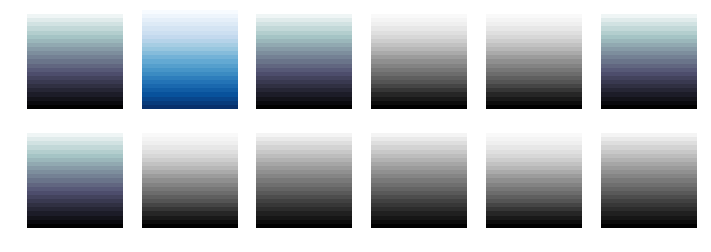

In [506]:
display_slices(y_val.reshape((nv, -1, 3))[:, :, None, :])

(2, 6)


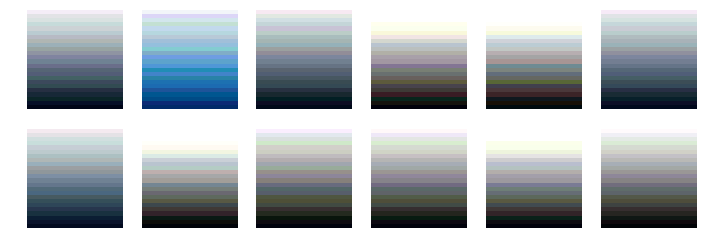

In [507]:
y_pred[y_pred < 0] = 0
y_pred[y_pred > 1] = 1
display_slices(y_pred.reshape((nv, -1, 3))[:, :, None, :])

In [508]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_pred, y_val))

0.04133098273041304